In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/185k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/371k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2768 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/232 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5534 [00:00<?, ? examples/s]

<Axes: title={'center': 'Emotion Distribution'}>

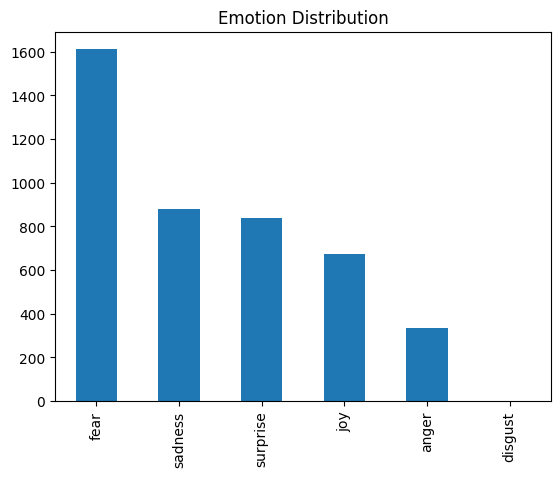

In [2]:
from datasets import load_dataset
import pandas as pd

#ds = load_dataset("aliabbasi1/BRIGHTER-emotion-categories", "eng", split="train")

dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")

df = pd.DataFrame(dataset['train'])

# Emotion frequency
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
df[emotions].sum().sort_values(ascending=False).plot(kind='bar', title="Emotion Distribution")

In [ ]:
from transformers import AutoTokenizer

label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']

# Use a pretrained Hugging Face model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(example):
    # Tokenize text
    tokenized = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    # Get labels
    tokenized["labels"] = [float(example[label]) for label in label_names]
    return tokenized

encoded_dataset = dataset.map(preprocess, batched=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2768 [00:00<?, ? examples/s]

Map:   0%|          | 0/232 [00:00<?, ? examples/s]

Map:   0%|          | 0/5534 [00:00<?, ? examples/s]

# Since we have a classification problem Encoder-Only Models are the best choice for this kind of Tasks. E.g. BERT

In [4]:
from transformers import AutoModelForSequenceClassification

#model_name = "bert-base-uncased"
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,  # number of emotions (excluding 'disgust')
    problem_type="multi_label_classification"
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
!pip install -U transformers

In [ ]:
from transformers import TrainingArguments, Trainer
import torch

def compute_metrics(eval_pred):
    from sklearn.metrics import f1_score
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (probs > 0.5).astype(int)
    return {
        "f1_micro": f1_score(labels, predictions, average="micro"),
        "f1_macro": f1_score(labels, predictions, average="macro"),
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=10,
)

In [7]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-7-0ef0c17888b3>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aliabbasi (aliabbasi-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.489200,0.418705,0.648079,0.542871
2,0.339900,0.385294,0.705107,0.644562


TrainOutput(global_step=346, training_loss=0.4145556874357896, metrics={'train_runtime': 598.222, 'train_samples_per_second': 9.254, 'train_steps_per_second': 0.578, 'total_flos': 183344688291840.0, 'train_loss': 0.4145556874357896, 'epoch': 2.0})

In [8]:
#trainer.evaluate(encoded_dataset["test"])

**model learns in the first 2 epochs and then quickly starts overfitting afterward**
Why?

**1. Small Dataset Size:**
The BRIGHTER emotion dataset is not large, especially per class.
Pretrained models like BERT are very powerful and learn patterns quickly, especially when the dataset is small.

**2. Model Capacity Is Too High:**
using a large pretrained language model, which has 66 million of parameters For a small task like BRIGHTER leads to overfitting.

**3. Class Imbalance:**
Some emotion categories are underrepresented.The model quickly becomes biased toward frequent classes, causing it to stop learning meaningful generalizations.

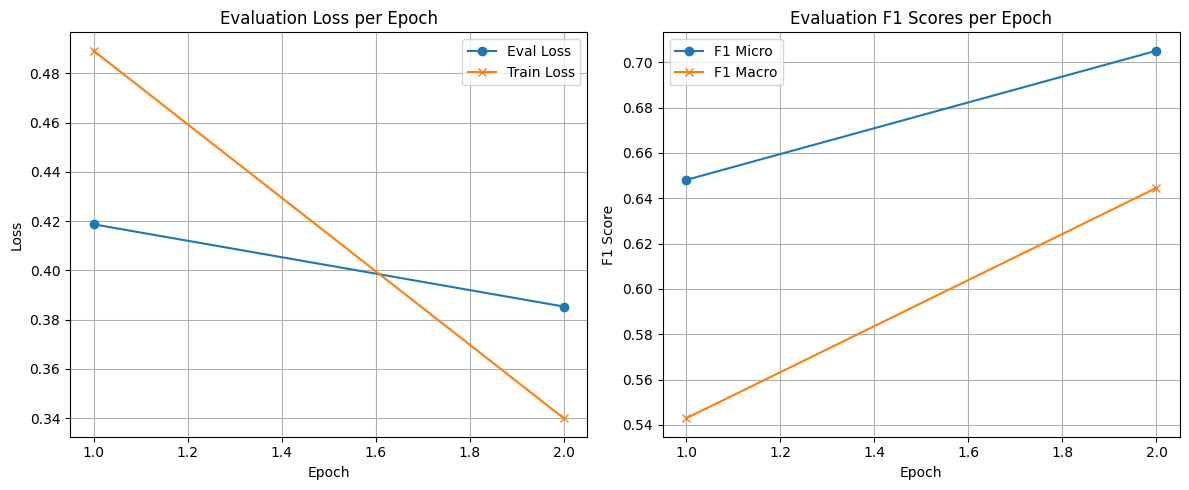

In [9]:
import matplotlib.pyplot as plt

# Extract log history (includes training and eval logs)
log_history = trainer.state.log_history

# Separate values
train_epochs = []
train_loss = []
eval_epochs = []
eval_loss = []
eval_f1_micro = []
eval_f1_macro = []

for log in log_history:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_epochs.append(log["epoch"])
        eval_loss.append(log["eval_loss"])
        eval_f1_micro.append(log["eval_f1_micro"])
        eval_f1_macro.append(log["eval_f1_macro"])

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(eval_epochs, eval_loss, marker='o', label="Eval Loss")
plt.plot(train_epochs, train_loss, marker='x', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evaluation Loss per Epoch")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_f1_micro, marker='o', label="F1 Micro")
plt.plot(eval_epochs, eval_f1_macro, marker='x', label="F1 Macro")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Evaluation F1 Scores per Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation on dev Dataset
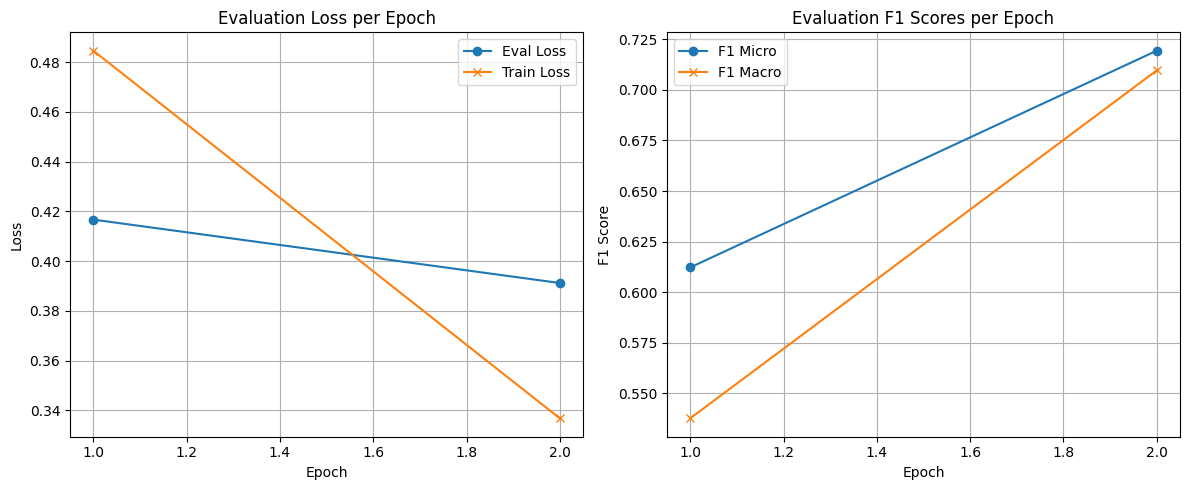

In [ ]:
from datasets import load_dataset
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Load BRIGHTER dev set
dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
dev_dataset = dataset["test"] 
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess(example):
    tokenized = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    tokenized["labels"] = [float(example[label]) for label in label_names]
    return tokenized

# Preprocess
encoded_test = dev_dataset.map(preprocess, batched=False) # Use dev_dataset here

# Evaluate using Trainer
metrics = trainer.evaluate(encoded_test)
print("Validation Metrics:", metrics)

# Predict raw logits using Trainer
raw_preds = trainer.predict(encoded_test)

# Convert logits to probabilities
probs = torch.sigmoid(torch.tensor(raw_preds.predictions)).numpy()

# Apply threshold (0.5) to get binary labels
binary_preds = (probs > 0.5).astype(int)

# Prepare submission file
submission_df = pd.DataFrame(binary_preds, columns=label_names)
submission_df.insert(0, "id", dev_dataset["id"]) # Use dev_dataset here as well

# Save to CSV
submission_df.to_csv("submission_test.csv", index=False)
print("Submission saved to submission_test.csv")

Map:   0%|          | 0/5534 [00:00<?, ? examples/s]

Validation Metrics: {'eval_loss': 0.38319113850593567, 'eval_f1_micro': 0.7088227943014247, 'eval_f1_macro': 0.6506838791433005, 'eval_runtime': 19.182, 'eval_samples_per_second': 288.499, 'eval_steps_per_second': 18.038, 'epoch': 2.0}
Submission saved to submission_test.csv


In [ ]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import precision_score, recall_score, f1_score

# Load submission file
submission_df = pd.read_csv("submission_test.csv")

# Load gold labels from 'dev' set
dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")
gold_df = pd.DataFrame(dataset["test"])

# Align dataframes by 'id'
label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']
submission_df = submission_df.set_index("id").sort_index()
gold_df = gold_df.set_index("id").sort_index()
submission_df = submission_df.loc[gold_df.index]
gold_labels = gold_df[label_names].astype(int)

# Calculate metrics
binary_preds = submission_df[label_names].values
true_labels = gold_labels.values

# Macro
precision_macro = precision_score(true_labels, binary_preds, average="macro", zero_division=0)
recall_macro = recall_score(true_labels, binary_preds, average="macro", zero_division=0)
f1_macro = f1_score(true_labels, binary_preds, average="macro", zero_division=0)

# Micro
precision_micro = precision_score(true_labels, binary_preds, average="micro", zero_division=0)
recall_micro = recall_score(true_labels, binary_preds, average="micro", zero_division=0)
f1_micro = f1_score(true_labels, binary_preds, average="micro", zero_division=0)

# Print report
print("Evaluation Metrics Breakdown")
print(" Macro Average:")
print(f"   Precision: {precision_macro:.4f}")
print(f"   Recall:    {recall_macro:.4f}")
print(f"   F1 Score:  {f1_macro:.4f}")
print("\n Micro Average:")
print(f"   Precision: {precision_micro:.4f}")
print(f"   Recall:    {recall_micro:.4f}")
print(f"   F1 Score:  {f1_micro:.4f}")


Evaluation Metrics Breakdown
 Macro Average:
   Precision: 0.7397
   Recall:    0.5978
   F1 Score:  0.6507

 Micro Average:
   Precision: 0.7491
   Recall:    0.6727
   F1 Score:  0.7088
